In [1]:
########## import some useful package ##########

import time
t1 = time.time()

import uproot
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import ripser
import persim

In [2]:
########## read the data ##########

processes = ["hhvv", "jjBG", "ttBG", "wwBG", "bbBG"]
event_type = [str(i)+"_500K" for i in processes]

Xsection = [4.0360050e-02, 5.799700e+01, 1.888510e+01, 1.506969e+02, 1.002750e+01]     ### unit: fb
Luminosity = 1000   ### unit: fb^-1
simulation_num = 500000

features = ["VLCjetR10N2", "VLCjetR10N2.PT", "VLCjetR10N2.Eta", "VLCjetR10N2.Phi", "VLCjetR10N2.Mass", "MissingET.MET"]

##### set data path #####

event_path = []
for type in event_type:
    event_path.append("/data/Chen-Wang/mucollider/" + type + "/delphes_output.root")

##### get the data file #####

data_file =[]
for path in event_path:
    data_file.append(uproot.open(path))
    
##### read data with features #####
events = []     ### total events
for process in processes:
    tmp_events = []
    for feature in features:
        tmp_events.append(data_file[processes.index(process)]["Delphes;1"][feature].array())
    tmp_events = np.expand_dims(tmp_events, axis=-1)
    tmp_events = tmp_events.transpose((1,0,2))
    tmp_events = np.squeeze(tmp_events,axis=(2,))
    events.append(tmp_events)
del tmp_events

In [3]:
########## define useful function ##########

def count(events):
    events_num = []
    for i, process in enumerate(processes):
        events_num.append(len(events[processes.index(process)]))
        print("There are", events_num[i], process, "events. Corresponding cross section:", Xsection[processes.index(process)]*events_num[i]/simulation_num, "(fb)")
        
##### select if Fat Jet >= 2 #####
        
def Fat_Jet_selection(events):
    where1 = np.where(events[:,features.index("VLCjetR10N2")]>=2)
    return events[where1]

##### select if M_jet > XX GeV #####

def mass_selection(events, mass_cut):
    where1 = []
    for i in range(len(events)):
        switch=1
        if events[i][features.index("VLCjetR10N2.Mass")][0]<mass_cut:
            switch=0
        if events[i][features.index("VLCjetR10N2.Mass")][1]<mass_cut:
            switch=0
        if switch==1:
            where1.append(i)
    return events[where1]

##### select if pT_J_leading > XX GeV #####

def pT_leading_selection(events, low_pT_cut, high_pT_cut):
    where1 = []
    for i in range(len(events)):
        switch = 1
        if events[i][features.index("VLCjetR10N2.PT")][0]<low_pT_cut:
            switch=0
        if events[i][features.index("VLCjetR10N2.PT")][0]>high_pT_cut:
            switch=0
        if switch==1:
            where1.append(i)
    return events[where1]

##### select if pT_J_subleading > XX GeV #####

def pT_subleading_selection(events, low_pT_cut, high_pT_cut):
    where1 = []
    for i in range(len(events)):
        switch = 1
        if events[i][features.index("VLCjetR10N2.PT")][1]<low_pT_cut:
            switch=0
        if events[i][features.index("VLCjetR10N2.PT")][1]>high_pT_cut:
            switch=0
        if switch==1:
            where1.append(i)
    return events[where1]

##### define X_HH #####

def X_HH(event):
    jet_mass1 = event[features.index("VLCjetR10N2.Mass")][0]
    jet_mass2 = event[features.index("VLCjetR10N2.Mass")][1]
    diff1 = jet_mass1 - 124
    diff2 = jet_mass2 - 124
    if diff1<diff2:
        m1 = jet_mass1
        m2 = jet_mass2
    else:
        m1 = jet_mass2
        m2 = jet_mass1
    return np.sqrt(((m1-124)/(0.1*m1+0.00001))**2 + ((m2-115)/(0.1*m2+0.00001))**2)


In [4]:
########## preselection ##########

print("Before any selection:")
count(events)

##### 2 fat jet selection #####

for process in processes:
    events[processes.index(process)] = Fat_Jet_selection(events[processes.index(process)])
print("\nAfter 2 fat jet selection:")
count(events)

Before any selection:
There are 500000 hhvv events. Corresponding cross section: 0.04036005 (fb)
There are 500000 jjBG events. Corresponding cross section: 57.997 (fb)
There are 500000 ttBG events. Corresponding cross section: 18.8851 (fb)
There are 500000 wwBG events. Corresponding cross section: 150.6969 (fb)
There are 500000 bbBG events. Corresponding cross section: 10.0275 (fb)

After 2 fat jet selection:
There are 500000 hhvv events. Corresponding cross section: 0.04036005 (fb)
There are 500000 jjBG events. Corresponding cross section: 57.997 (fb)
There are 500000 ttBG events. Corresponding cross section: 18.8851 (fb)
There are 467153 wwBG events. Corresponding cross section: 140.7970178514 (fb)
There are 500000 bbBG events. Corresponding cross section: 10.0275 (fb)


In [5]:
########## visualization of kinematics ##########

m_J_leading = []
m_J_subleading = []
pt_J_leading = []
pt_J_subleading = []
missET = []

##### calculate jet mass #####

for process in processes:
    tmp_m1 = []
    tmp_m2 = []
    tmp_pt1 = []
    tmp_pt2 = []
    tmp_met = []
    for i in range(len(events[processes.index(process)])):
        tmp_m1.append(events[processes.index(process)][i][features.index("VLCjetR10N2.Mass")][0])
        tmp_m2.append(events[processes.index(process)][i][features.index("VLCjetR10N2.Mass")][1])
        tmp_pt1.append(events[processes.index(process)][i][features.index("VLCjetR10N2.PT")][0])
        tmp_pt2.append(events[processes.index(process)][i][features.index("VLCjetR10N2.PT")][1])
        tmp_met.append(events[processes.index(process)][i][features.index("MissingET.MET")][0])
    m_J_leading.append(tmp_m1)
    m_J_subleading.append(tmp_m2)
    pt_J_leading.append(tmp_pt1)
    pt_J_subleading.append(tmp_pt2)
    missET.append(tmp_met)
    print("Time:{:^8.4f}(s)".format(time.time()-t1))
del tmp_m1, tmp_m2, tmp_pt1, tmp_pt2, tmp_met

Time:18.0203 (s)
Time:19.3728 (s)
Time:20.7544 (s)
Time:22.0641 (s)
Time:23.4929 (s)


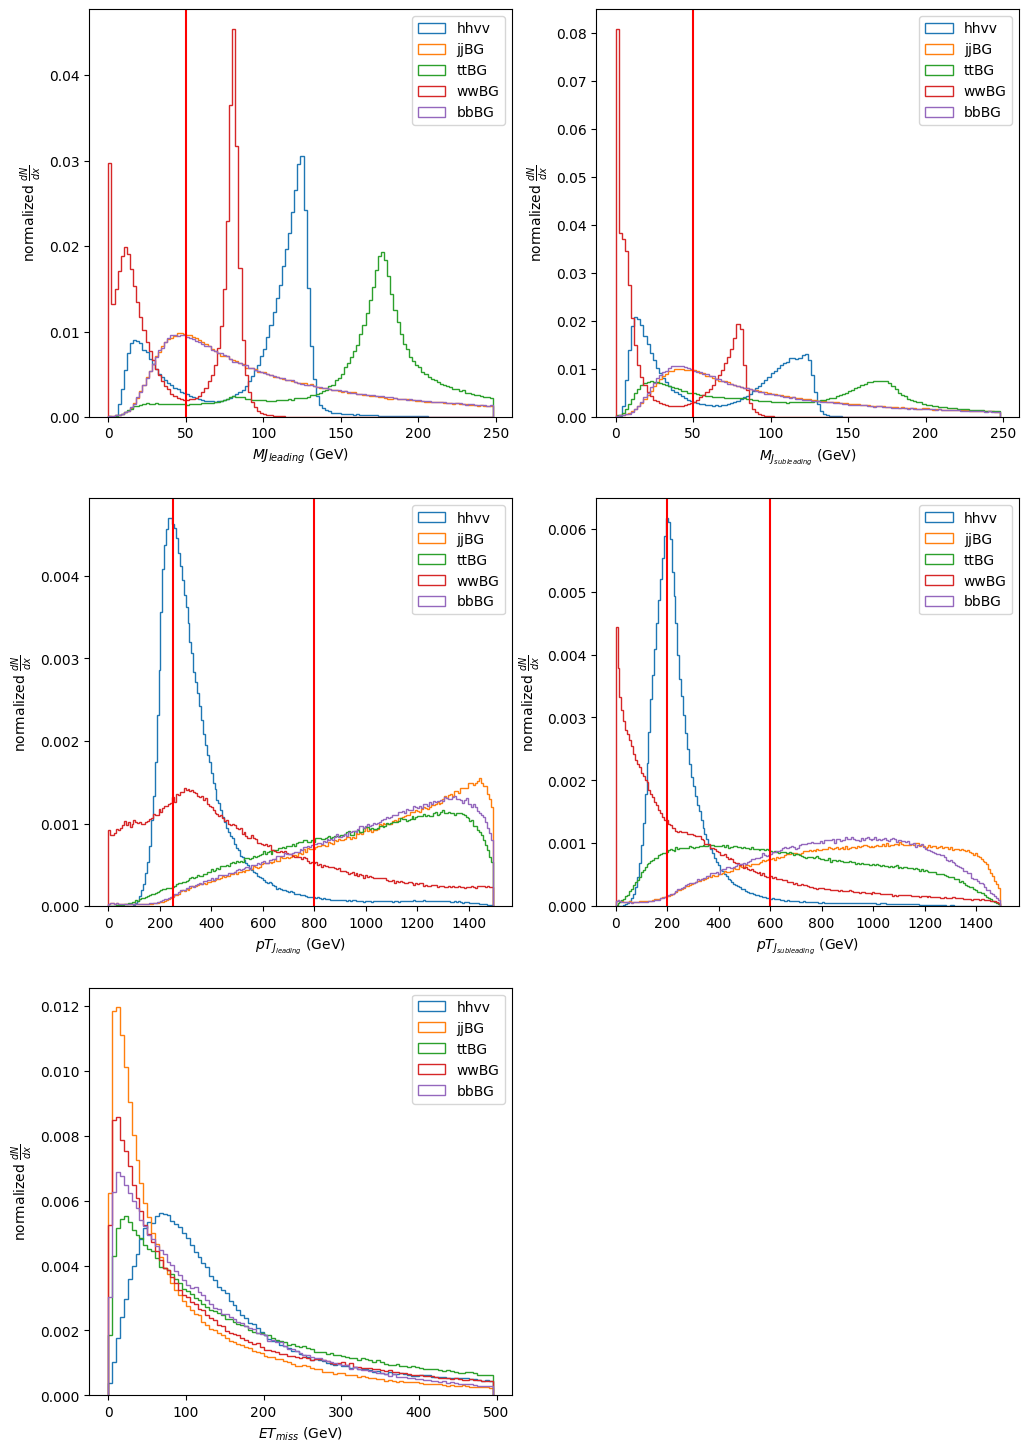

In [6]:
##### plot the histogram #####

fig = plt.figure(figsize=(12, 18))

fig.add_subplot(321)     ### plot leading jet mass
bins = np.arange(0,250,2)
for process in processes:
    plt.hist(m_J_leading[processes.index(process)], bins=bins, label=process, histtype='step', density=True)
plt.axvline(50, color='r')
plt.xlabel(r"$M{J_{leading}} ~\rm{(GeV)}$", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

fig.add_subplot(322)     ### plot subleading jet mass
bins = np.arange(0,250,2)
for process in processes:
    plt.hist(m_J_subleading[processes.index(process)], bins=bins, label=process, histtype='step', density=True)
plt.axvline(50, color='r')
plt.xlabel(r"$M_{J_{subleading}} ~\rm{(GeV)}$", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

fig.add_subplot(323)     ### plot leading jet PT
bins = np.arange(0,1500,7.5)
for process in processes:
    plt.hist(pt_J_leading[processes.index(process)], bins=bins, label=process, histtype='step', density=True)
plt.axvline(250, color='r')
plt.axvline(800, color='r')
plt.xlabel(r"$pT_{J_{leading}} ~\rm{(GeV)}$", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

fig.add_subplot(324)     ### plot subleading jet PT
bins = np.arange(0,1500,7.5)
for process in processes:
    plt.hist(pt_J_subleading[processes.index(process)], bins=bins, label=process, histtype='step', density=True)
plt.axvline(200, color='r')
plt.axvline(600, color='r')
plt.xlabel(r"$pT_{J_{subleading}} ~\rm{(GeV)}$", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

fig.add_subplot(325)     ### plot MET
bins = np.arange(0,500,5)
for process in processes:
    plt.hist(missET[processes.index(process)], bins=bins, label=process, histtype='step', density=True)
plt.xlabel(r"$ET_{miss} ~\rm{(GeV)}$", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

plt.show()

In [7]:
########## Do some basic cuts ##########

##### jet mass selection #####

jet_mass_cut = 50   ### GeV
for process in processes:
    events[processes.index(process)] = mass_selection(events[processes.index(process)], jet_mass_cut)
print("After jet mass selection:")
count(events)

##### leading jet pT selection #####

leading_low_pT_cut = 250   ### GeV
leading_high_pT_cut = 800   ### GeV
for process in processes:
    events[processes.index(process)] = pT_leading_selection(events[processes.index(process)], leading_low_pT_cut, leading_high_pT_cut)
print("\nAfter leading jet pT selection:")
count(events)

##### subleading jet pT selection #####

subleading_low_pT_cut = 200   ### GeV
subleading_high_pT_cut = 600   ### GeV
for process in processes:
    events[processes.index(process)] = pT_subleading_selection(events[processes.index(process)], subleading_low_pT_cut, subleading_high_pT_cut)
print("\nAfter subleading jet pT selection:")
count(events)

After jet mass selection:
There are 215975 hhvv events. Corresponding cross section: 0.0174335235975 (fb)
There are 302128 jjBG events. Corresponding cross section: 35.045035232000004 (fb)
There are 373275 ttBG events. Corresponding cross section: 14.098671405000001 (fb)
There are 154694 wwBG events. Corresponding cross section: 46.6238124972 (fb)
There are 294818 bbBG events. Corresponding cross section: 5.91257499 (fb)

After leading jet pT selection:
There are 169263 hhvv events. Corresponding cross section: 0.0136629262863 (fb)
There are 50716 jjBG events. Corresponding cross section: 5.8827517039999995 (fb)
There are 93706 ttBG events. Corresponding cross section: 3.5392943612 (fb)
There are 88938 wwBG events. Corresponding cross section: 26.805361784400002 (fb)
There are 54414 bbBG events. Corresponding cross section: 1.09127277 (fb)

After subleading jet pT selection:
There are 148817 hhvv events. Corresponding cross section: 0.0120125231217 (fb)
There are 32622 jjBG events. Cor

In [8]:
# data_file[processes=="hhvv"]["Delphes;1"].show()

##### show the event #####

events[0][0]

array([2, array([400.477 , 237.4986], dtype=float32),
       array([-0.6328368,  1.2287327], dtype=float32),
       array([ 1.9683698 , -0.34592408], dtype=float32),
       array([131.92996, 106.21863], dtype=float32),
       array([285.02875], dtype=float32)], dtype=object)

In [9]:
print("Time:{:^8.4f}(s)".format(time.time()-t1))

Time:76.9707 (s)
